## Directory Structure
PLEASE make sure your directory looks like this:
- root_dir
    - pixel-nerf (clone/pull from github)
    - adaptive-volume-rendering (clone/pull from github)
        - 6S980_Project.ipynb
    - scene-representation-networks (clone/pull from github)
    - data
    - checkpoints
    - ......
    
Then set your pwd to root_dir

## Relevant Repos

- PixelNeRF repo: https://github.com/sxyu/pixel-nerf

- SRN repo: https://github.com/vsitzmann/scene-representation-networks

- SRN raymarcher algorithm: https://github.com/vsitzmann/scene-representation-networks/blob/master/custom_layers.py

## Data

- Currently using cars dataset from SRN

## What we did

- Now the pixelnerf with pretrained weights are running!


## Questions
- PixelNeRF currently does: evenly coarse sampling - fine sampling via importance weights - fine sampling around expected depth. With adaptive procedure, what is a fair comparison?

## TODOs
- First attempt: let LSTM interact with the features, do 10 steps, then directly output a color
- Second attempt: sample points around the final location and do volume integral

- Use view 64 to render out videos

In [1]:
root_dir = "/Users/yankesong/Documents/YankeSong/Harvard Textbook/MIT 6.S980/Project/"       # This is the only thing you need to change.
%cd "/Users/yankesong/Documents/YankeSong/Harvard Textbook/MIT 6.S980/Project/"

# root_dir = "/Users/jameszli/desktop/MIT/6.S980/"       # This is the only thing you need to change.
# %cd "/Users/jameszli/desktop/MIT/6.S980/"

# root_dir = "/home/ysong/project/"       # This is the only thing you need to change.
# %cd "/home/ysong/project/" 

# # Install everything
# %pip install -r adaptive-volume-rendering/requirements.txt

# Import everything
import sys

sys.path.insert(0, f"{root_dir}/pixel-nerf/src/")
sys.path.insert(0, f"{root_dir}/adaptive-volume-rendering/")

from model import make_model, loss
from dataset import *
from models import *
from renderers import *
from trains import *
from utils import *


print(f"Installed Torch version: {torch.__version__}")

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print(device)

/Users/yankesong/Documents/YankeSong/Harvard Textbook/MIT 6.S980/Project


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Installed Torch version: 1.13.0
cpu


## Setup & Load Test Data

In [2]:
# # Download data and weights

# # Make a new directory
# !mkdir data
# !mkdir checkpoints

# # Download Test Dataset
# if not os.path.exists(f"{root_dir}data/cars_train.hdf5"):
#     # Download SRNs-cars dataset
#     gdown.download("https://drive.google.com/uc?id={}".format("1SBjlsizq0sFNkCZxMQh-pNRi0HyFozKb"),f"{root_dir}data/cars_train.hdf5")


# ## Download pretrained weights from PixelNeRF
# if not os.path.exists(f"{root_dir}checkpoints/pixel_nerf_weights.zip"):
#   gdown.download("https://drive.google.com/uc?id={}".format("1UO_rL201guN6euoWkCOn-XpqR2e8o6ju"),f"{root_dir}checkpoints/pixel_nerf_weights.zip")
#   !unzip checkpoints/pixel_nerf_weights.zip -d checkpoints/

## Volume Renderer

In [6]:
# ############## Original Volume renderer
# Create a custom conf
# from pyhocon import ConfigFactory
# conf = ConfigFactory.parse_file(f"adaptive-volume-rendering/conf/default_mv.conf")

# # Create a pixelnerf net
# net = make_new_model(conf["model"]).to(device=device)
# net.stop_encoder_grad = True

# # Load pretrianed weights
# # model_path = f"{root_dir}checkpoints/srn_car/pixel_nerf_latest"
# # net.load_weights(model_path)

# # Combine with volumerenderer
# renderer = VolumeRenderer.from_conf(conf["normal_renderer"]).to(
#     device=device
# )
# max_num_instances = 2150
# samples_per_instance = 8

# rf_and_renderer = RadFieldAndRenderer(net, renderer).to(device=device)
# model_path = f"{root_dir}checkpoints/experiment/vr_{max_num_instances}cars_{samples_per_instance}samples_40000steps"
# rf_and_renderer.load_weights(model_path)
# # Test dataset
# sl = 32
# max_num_instances = 2150
# train_dataset = SceneClassDataset(root_dir=f"{root_dir}data/cars_train",
#                                              max_num_instances=10,
#                                              max_observations_per_instance=250,
#                                              img_sidelength=sl,
#                                              specific_observation_idcs=None,
#                                              samples_per_instance=samples_per_instance)


# train_dataloader = DataLoader(train_dataset,
#                                       batch_size=1,
#                                       shuffle=True,
#                                       drop_last=True,
#                                       collate_fn=train_dataset.collate_fn
#                                       )

# # Configurations
# optim = torch.optim.Adam(lr=1e-4, params=rf_and_renderer.parameters())

    
# try:
#     _ = fit(net,
#         rf_and_renderer, 
#         train_dataloader, 
#         loss_fn=mse_loss, 
#         resolution=(sl, sl, 3), 
#         plotting_function=plot_output_ground_truth, 
#         optimizer=optim, 
#         total_steps=100,
#         steps_til_summary=1
#         )
#     model_path = f"{root_dir}checkpoints/experiment/vr_{max_num_instances}cars_{samples_per_instance}samples_40000steps"
#     rf_and_renderer.save_weights(model_path)
# except Exception:
#     print(traceback.format_exc())

Using torchvision resnet34 encoder


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


encoder.model.conv1.weight
encoder.model.bn1.weight
encoder.model.bn1.bias
encoder.model.layer1.0.conv1.weight
encoder.model.layer1.0.bn1.weight
encoder.model.layer1.0.bn1.bias
encoder.model.layer1.0.conv2.weight
encoder.model.layer1.0.bn2.weight
encoder.model.layer1.0.bn2.bias
encoder.model.layer1.1.conv1.weight
encoder.model.layer1.1.bn1.weight
encoder.model.layer1.1.bn1.bias
encoder.model.layer1.1.conv2.weight
encoder.model.layer1.1.bn2.weight
encoder.model.layer1.1.bn2.bias
encoder.model.layer1.2.conv1.weight
encoder.model.layer1.2.bn1.weight
encoder.model.layer1.2.bn1.bias
encoder.model.layer1.2.conv2.weight
encoder.model.layer1.2.bn2.weight
encoder.model.layer1.2.bn2.bias
encoder.model.layer2.0.conv1.weight
encoder.model.layer2.0.bn1.weight
encoder.model.layer2.0.bn1.bias
encoder.model.layer2.0.conv2.weight
encoder.model.layer2.0.bn2.weight
encoder.model.layer2.0.bn2.bias
encoder.model.layer2.0.downsample.0.weight
encoder.model.layer2.0.downsample.1.weight
encoder.model.layer2.0.

### PixelNeRF + Raymarcher only

In [4]:
# # Create a custom conf
# from pyhocon import ConfigFactory
# conf = ConfigFactory.parse_file(f"{root_dir}adaptive-volume-rendering/conf/default_mv.conf")

# # Create a pixelnerf net
# net = make_new_model(conf["model"]).to(device=device)
# net.stop_encoder_grad = True
# # Combine with volumerenderer
# renderer = Raymarcher.from_conf(conf["raymarcher"]).to(
#     device=device
# )

# rf_and_renderer = RadFieldAndRenderer(net, renderer).to(device=device)
# model_path = f"{root_dir}checkpoints/experiment/newraymarcher_2150cars_8samples_50ksteps"
# rf_and_renderer.load_weights(model_path)
# # own_state = rf_and_renderer.state_dict()
# # load_state = torch.load(model_path, map_location=device)
# # for name, param in load_state.items():
# #     if name not in own_state:
# #         continue
# #     if isinstance(param, nn.Parameter):
# #         # backwards compatibility for serialized parameters
# #         param = param.data
# #     own_state[name].copy_(param)

# max_num_instances = 2150
# samples_per_instance = 8

# # Freeze nerf weights
# for param in net.parameters():
#     param.requires_grad = False


# ######## TODO
# # Test dataset
# sl = 32
# max_num_instances = 2150
# train_dataset = SceneClassDataset(root_dir=f"{root_dir}data/cars_train",
#                                              max_num_instances=max_num_instances,
#                                              max_observations_per_instance=250,
#                                              img_sidelength=sl,
#                                              specific_observation_idcs=None,
#                                              samples_per_instance=samples_per_instance)


# train_dataloader = DataLoader(train_dataset,
#                                       batch_size=1,
#                                       shuffle=True,
#                                       drop_last=True,
#                                       collate_fn=train_dataset.collate_fn
#                                       )

# # Configurations
# optim = torch.optim.Adam(lr=1e-4, params=rf_and_renderer.parameters())

# try:
#     _ = fit(net,
#         rf_and_renderer, 
#         train_dataloader, 
#         loss_fn=mse_regularization_loss, 
#         resolution=(sl, sl, 3), 
#         plotting_function=plot_output_ground_truth, 
#         optimizer=optim, 
#         total_steps=50000,
#         steps_til_summary=200
#         )
#     model_path = f"{root_dir}checkpoints/experiment/newraymarcher_{max_num_instances}cars_{samples_per_instance}samples_100ksteps"
#     rf_and_renderer.save_weights(model_path)
# except Exception:
#     print(traceback.format_exc())
    
# try:
#     _ = fit(net,
#         rf_and_renderer, 
#         train_dataloader, 
#         loss_fn=mse_regularization_loss, 
#         resolution=(sl, sl, 3), 
#         plotting_function=plot_output_ground_truth, 
#         optimizer=optim, 
#         total_steps=50000,
#         steps_til_summary=200
#         )
#     model_path = f"{root_dir}checkpoints/experiment/newraymarcher_{max_num_instances}cars_{samples_per_instance}samples_150ksteps"
#     rf_and_renderer.save_weights(model_path)
# except Exception:
#     print(traceback.format_exc())
    

   


### PixelNeRF + Raymarcher, retrained

In [5]:
# # Create a custom conf
# from pyhocon import ConfigFactory
# conf = ConfigFactory.parse_file(f"{root_dir}adaptive-volume-rendering/conf/default_mv.conf")

# # Create a pixelnerf net
# net = make_new_model(conf["model"]).to(device=device)
# net.stop_encoder_grad = True
# # model_path = f"{root_dir}checkpoints/srn_car/pixel_nerf_latest"
# # net.load_weights(model_path)
# # Combine with volumerenderer
# renderer = Raymarcher.from_conf(conf["raymarcher"]).to(
#     device=device
# )

# rf_and_renderer = RadFieldAndRenderer(net, renderer).to(device=device)

# max_num_instances = 2150
# samples_per_instance = 8

# # Load pretrianed weights

# model_path = f"{root_dir}checkpoints/experiment/newraymarcher_{max_num_instances}cars_{samples_per_instance}samples_400ksteps"
# rf_and_renderer.load_weights(model_path)


# # Freeze nerf weights
# # for param in net.parameters():
# #     param.requires_grad = False


# ######## TODO
# # Test dataset
# sl = 32
# max_num_instances = 2150
# train_dataset = SceneClassDataset(root_dir=f"{root_dir}data/cars_train",
#                                              max_num_instances=max_num_instances,
#                                              max_observations_per_instance=250,
#                                              img_sidelength=sl,
#                                              specific_observation_idcs=None,
#                                              samples_per_instance=samples_per_instance)


# train_dataloader = DataLoader(train_dataset,
#                                       batch_size=1,
#                                       shuffle=True,
#                                       drop_last=True,
#                                       collate_fn=train_dataset.collate_fn
#                                       )

# # Configurations
# optim = torch.optim.Adam(lr=1e-4, params=rf_and_renderer.parameters())

# try:
#     _ = fit(net,
#         rf_and_renderer, 
#         train_dataloader, 
#         loss_fn=mse_regularization_loss, 
#         resolution=(sl, sl, 3), 
#         plotting_function=plot_output_ground_truth, 
#         optimizer=optim, 
#         total_steps=50000,
#         steps_til_summary=200
#         )
#     model_path = f"{root_dir}checkpoints/experiment/newraymarcher_{max_num_instances}cars_{samples_per_instance}samples_500ksteps"
#     rf_and_renderer.save_weights(model_path)
# except Exception:
#     print(traceback.format_exc())



### PixelNeRF + Adaptive Volume Renderer

In [6]:
# # Create a custom conf
# from pyhocon import ConfigFactory
# conf = ConfigFactory.parse_file(f"adaptive-volume-rendering/conf/default_mv.conf")

# # Create a pixelnerf net
# net = make_new_model(conf["model"]).to(device=device)
# net.stop_encoder_grad = True

# # Combine with volumerenderer
# renderer = AdaptiveVolumeRenderer.from_conf(conf["adaptive_renderer"]).to(device=device)

# rf_and_renderer = RadFieldAndRenderer(net, renderer).to(device=device)


# max_num_instances = 2150
# samples_per_instance = 8

# # Load pretrianed weights
# model_path = f"{root_dir}checkpoints/experiment/avr_{max_num_instances}cars_{samples_per_instance}samples_20ksteps"
# rf_and_renderer.load_weights(model_path)

# # own_state = rf_and_renderer.state_dict()
# # load_state = torch.load(model_path, map_location=device)
# # for name, param in load_state.items():
# #     if name not in own_state:
# #         continue
# #     if isinstance(param, nn.Parameter):
# #         # backwards compatibility for serialized parameters
# #         param = param.data
# #     own_state[name].copy_(param)
    

# ######## TODO
# # Test dataset
# sl = 32

# train_dataset = SceneClassDataset(root_dir=f"{root_dir}data/cars_train",
#                                              max_num_instances=max_num_instances,
#                                              max_observations_per_instance=250,
#                                              img_sidelength=sl,
#                                              specific_observation_idcs=None,
#                                              samples_per_instance=samples_per_instance)


# train_dataloader = DataLoader(train_dataset,
#                                       batch_size=1,
#                                       shuffle=True,
#                                       drop_last=True,
#                                       collate_fn=train_dataset.collate_fn
#                                       )

# # Configurations
# optim = torch.optim.Adam(lr=1e-4, params=rf_and_renderer.parameters())

# try:
#     _ = fit(net,
#         rf_and_renderer, 
#         train_dataloader, 
#         loss_fn=mse_loss, 
#         resolution=(sl, sl, 3), 
#         plotting_function=plot_output_ground_truth, 
#         optimizer=optim, 
#         total_steps=20000,
#         steps_til_summary=100
#         )
#     model_path = f"{root_dir}checkpoints/experiment/avr_{max_num_instances}cars_{samples_per_instance}samples_40ksteps"
#     rf_and_renderer.save_weights(model_path)
# except Exception:
#     print(traceback.format_exc())


## Render a video

Using torchvision resnet34 encoder


/home/ysong/anaconda3/envs/adaptivevolumerendering/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ysong/anaconda3/envs/adaptivevolumerendering/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Load /home/ysong/project/checkpoints/experiment/avr_2150cars_8samples_40ksteps


/home/ysong/anaconda3/envs/adaptivevolumerendering/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1666642991888/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


it takes 13.298009395599365 seconds to render a video


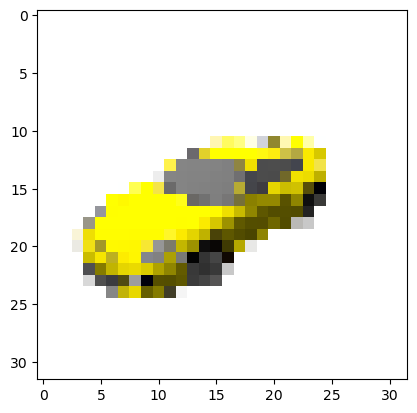

In [7]:
# Volume Renderer

max_num_instances = 2150
samples_per_instance = 8

# Import model
from pyhocon import ConfigFactory
conf = ConfigFactory.parse_file(f"{root_dir}adaptive-volume-rendering/conf/default_mv.conf")

net = make_new_model(conf["model"]).to(device=device)
net.stop_encoder_grad = True

# renderer = Raymarcher.from_conf(conf["raymarcher"]).to(device=device)
# renderer = VolumeRenderer.from_conf(conf["normal_renderer"]).to(device=device)
renderer = AdaptiveVolumeRenderer.from_conf(conf["adaptive_renderer"]).to(device=device)
rf_and_renderer = RadFieldAndRenderer(net, renderer).to(device=device)

# Load pretrianed weights
# model_path = f"{root_dir}checkpoints/experiment/newraymarcher_{max_num_instances}cars_{samples_per_instance}samples_400ksteps"
# model_path = f"{root_dir}checkpoints/experiment/vr_{max_num_instances}cars_{samples_per_instance}samples_40000steps"
model_path = f"{root_dir}checkpoints/experiment/avr_{max_num_instances}cars_{samples_per_instance}samples_40ksteps"

rf_and_renderer.load_weights(model_path)


# Load test image
sl = 32
video_dataset = SceneClassDataset(root_dir=f"{root_dir}data/cars_val",
                                             max_num_instances=1,
                                             max_observations_per_instance=250,
                                             img_sidelength=sl,
                                             specific_observation_idcs=[64],
                                             samples_per_instance=1)


video_dataloader = DataLoader(video_dataset,
                                      batch_size=1,
                                      shuffle=True,
                                      drop_last=True,
                                      collate_fn=video_dataset.collate_fn
                                      )

video_mi = next(iter(video_dataloader))
plt.imshow(video_mi['images'][0].reshape(sl,sl,3))
plt.savefig('videos/img.png')

import time

start = time.time()
frames = generate_video(video_mi, 360, 1.5, net, rf_and_renderer)
end = time.time()
print(f'it takes {end - start} seconds to render a video')

# Make a video
type = 'avr'
f = f'videos/video_{type}.gif'
imageio.mimwrite(f, frames, fps=60)
f = f'videos/video_{type}.mp4'
imageio.mimwrite(f, frames, fps=60, quality=7)

from IPython.display import HTML
from base64 import b64encode
mp4 = open(f,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## Calculate metrics

In [9]:
# Raymarcher

max_num_instances = 2150
samples_per_instance = 8

# Import model
from pyhocon import ConfigFactory
conf = ConfigFactory.parse_file(f"{root_dir}adaptive-volume-rendering/conf/default_mv.conf")

net = make_new_model(conf["model"]).to(device=device)
net.stop_encoder_grad = True

# renderer = VolumeRenderer.from_conf(conf["normal_renderer"]).to(device=device)
# renderer = Raymarcher.from_conf(conf["raymarcher"]).to(device=device)
renderer = AdaptiveVolumeRenderer.from_conf(conf["adaptive_renderer"]).to(device=device)
rf_and_renderer = RadFieldAndRenderer(net, renderer).to(device=device)

# Load pretrianed weights
# model_path = f"{root_dir}checkpoints/experiment/vr_{max_num_instances}cars_{samples_per_instance}samples_40000steps"
# model_path = f"{root_dir}checkpoints/experiment/raymarcher_{max_num_instances}cars_{samples_per_instance}samples_400ksteps"
model_path = f"{root_dir}checkpoints/experiment/avr_{max_num_instances}cars_{samples_per_instance}samples_40ksteps"
rf_and_renderer.load_weights(model_path)

# metrics
sl = 32
val_dir = f"{root_dir}data/cars_val"
n_val = 352
psnr, ssim = get_psnr(net, rf_and_renderer, val_dir, n_val, sl, [64])
print(psnr)
print(ssim)

Using torchvision resnet34 encoder
Load /home/ysong/project/checkpoints/experiment/avr_2150cars_8samples_40ksteps
object number 0


/home/ysong/project//adaptive-volume-rendering/utils.py:359: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  ssim = skimage.measure.compare_ssim(rgb, gt, multichannel=True, data_range=1)
/home/ysong/project//adaptive-volume-rendering/utils.py:360: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  psnr = skimage.measure.compare_psnr(rgb, gt, data_range=1)


object number 1
object number 2
object number 3
object number 4
object number 5
object number 6
object number 7
object number 8
object number 9
object number 10
object number 11
object number 12
object number 13
object number 14
object number 15
object number 16
object number 17
object number 18
object number 19
object number 20
object number 21
object number 22
object number 23
object number 24
object number 25
object number 26
object number 27
object number 28
object number 29
object number 30
object number 31
object number 32
object number 33
object number 34
object number 35
object number 36
object number 37
object number 38
object number 39
object number 40
object number 41
object number 42
object number 43
object number 44
object number 45
object number 46
object number 47
object number 48
object number 49
object number 50
object number 51
object number 52
object number 53
object number 54
object number 55
object number 56
object number 57
object number 58
object number 59
object